In [17]:
import json
import torch
import torch.nn as nn
import torch.utils.data
import math
import torch.nn.functional as F
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from collections import Counter
from torchinfo import summary
from sklearn.decomposition import PCA
from torch.utils.data import Dataset

In [18]:
# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,visi filkom,menjadi fakultas yang berdaya saing internasio...
1,misi filkom,menyelenggarakan pendidikan di bidang teknolog...
2,apa tujuan filkom?,"menghasilkan lulusan yang kompeten , profesion..."
3,sasaran pendidikan filkom,meningkatkan kompetensi dan kualifikasi pendid...
4,email fitra a. bachtiar,fitra.bachtiar[at]ub.ac.id
5,bidang penelitian fitra a. bachtiar,"affective computing, affective engineering, in..."
6,tanggal dibentuk ptiik,27 oktober 2011
7,sasaran pengabdian filkom,1. meningkatkan kualitas dan kuantitas pengabd...
8,sasaran kerjasama filkom,"1. mengadakan kerjasama pendidikan, penlitian ..."
9,dekan fakultas ilmu komputer filkom,"prof. ir. wayan firdaus mahmudy, s.si., mt., p..."


In [19]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [20]:
pairs = []
max_len = 90

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())

    if len(first) == 0 or len(second) == 0:
        continue

    
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

In [21]:
pairs_df = pd.DataFrame(pairs, columns=['question', 'answer'])
pairs_df

,question,answer
0,"[visi, filkom]","[menjadi, fakultas, yang, berdaya, saing, inte..."
1,"[misi, filkom]","[menyelenggarakan, pendidikan, di, bidang, tek..."
2,"[apa, tujuan, filkom]","[menghasilkan, lulusan, yang, kompeten, profes..."
3,"[sasaran, pendidikan, filkom]","[meningkatkan, kompetensi, dan, kualifikasi, p..."
4,"[email, fitra, a, bachtiar]",[fitrabachtiaratubacid]
5,"[bidang, penelitian, fitra, a, bachtiar]","[affective, computing, affective, engineering,..."
6,"[tanggal, dibentuk, ptiik]",[oktober]
7,"[sasaran, pengabdian, filkom]","[meningkatkan, kualitas, dan, kuantitas, penga..."
8,"[sasaran, kerjasama, filkom]","[mengadakan, kerjasama, pendidikan, penlitian,..."
9,"[dekan, fakultas, ilmu, komputer, filkom]","[prof, ir, wayan, firdaus, mahmudy, ssi, mt, phd]"


In [22]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [23]:
min_word_freq = 0
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [24]:
print("Total words are: {}".format(len(word_map)))

Total words are: 440


In [25]:
with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

In [26]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c


def encode_question_left(words, word_map):
    enc_c = [word_map['<pad>']] * (max_len - len(words)) + [word_map.get(word, word_map['<unk>']) for word in words]
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

In [27]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    # qus = encode_question_left(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [28]:

knowledgebase_url_test = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_eval.xlsx'
knowledgebase_test = pd.read_excel(knowledgebase_url_test)

In [29]:
knowledgebase_test

,Pertanyaan,Labels,Jawaban
0,apa visi fakultas,visi,menjadi fakultas yang berdaya saing internasio...
1,visi dari filkom,visi,menjadi fakultas yang berdaya saing internasio...
2,apa saja visi filkom,visi,menjadi fakultas yang berdaya saing internasio...
3,apa misi fakultas,misi,menyelenggarakan pendidikan di bidang teknolog...
4,apa saja misi flkom,misi,menyelenggarakan pendidikan di bidang teknolog...
...,...,...,...
86,dapatkah anda memberi tahu siapa konselor bimb...,other,ada 2 konselor bimbingan dan konseling di filk...
87,siapa yang menjadi koordinator konselor sebaya?,other,koordinator konselor sebaya adalah muhammad da...
88,siapa koordinator untuk konselor sebaya?,other,koordinator konselor sebaya adalah muhammad da...
89,mohon rincian mengenai layanan ultksp.,other,rincian layanan ultksp dapat diakses pada taut...


In [30]:
truncated_real_answers = []
for i in list(knowledgebase_test['Jawaban']):
    cleaned = remove_punc(i)
    splited = cleaned.split()
    truncated_real_answers.append(' '.join(splited[:50]))

real_questions = list(knowledgebase_test['Pertanyaan'])

In [31]:
real_questions

['apa visi fakultas',
 'visi dari filkom',
 'apa saja visi filkom',
 'apa misi fakultas',
 'apa saja misi flkom',
 'apa misi filkom',
 'bagaimana tujuan filkom',
 'apa tujuan filkom',
 'pendidikan saran filkom',
 'apa saja sasaran dari filkom',
 'apa sasaran pendidikan filkom',
 'apa email pak fitra',
 'email e pak fitra teh naon',
 'apa email fitra a. bachtiar',
 'pak fitra penelitian di bidang apa',
 'bidang penelitian pak fitra',
 'tanggal tanggal pembentukan ptiik',
 'tanggal dibentuk ptiik',
 'sasaran filkom untuk pengabdian apa saja',
 'apa saja sasaran pengabdian filkom',
 'sasaran dari kerjasama filkom apa saja ya',
 'apa saja sasaran kerjasama filkom',
 'dekan filkom the saha',
 'siapa dekan fakultas ilmu komputer filkom',
 'wajuk dekan 1 filkom saha',
 'wakil dekan bidang akademik filkom siapa ya',
 'siapa wakil dekan 2 filkom',
 'wakil dekan bidang umum, keuangan, dan sumber daya / wakil dekan 2',
 'siapa wakil dekan bidang kemahasiswaan 3',
 'wakil dekan bidang kemahasiswaa

In [32]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

## Train Loader

In [33]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

In [34]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

In [35]:
import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at {path}")
    else:
        print(f"Directory already exists at {path}")

# Architecture

## Embeddings

In [36]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

## Multi-Head Attention

In [37]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

## Feed Forward Neural Network

In [38]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out


## Encoder

In [39]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## Decoder

In [40]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded


## Transformer Architecture

In [41]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers_enc, num_layers_dec, word_map, max_len = 50):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.vocab_size = len(word_map)
        self.embed_enc = Embeddings(self.vocab_size, d_model, num_layers = num_layers_enc, max_len = max_len)
        self.embed_dec = Embeddings(self.vocab_size, d_model, num_layers = num_layers_dec, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            src_embeddings = self.embed_enc(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            tgt_embeddings = self.embed_enc(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        print("size of encoded", encoded.size())
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out


In [42]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       
        

In [43]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss
        

# Define Neptune Experiment

In [44]:
project = "andialifs/fluent-tesis-playground-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

def neptune_init(name="cobain"):
    run = neptune.init_run(
        project=project,
        api_token=api_token,
        name=name
    )
    return run

# Function

In [45]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

## Train

In [46]:
def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

## Evaluate

In [47]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Transformers

# Training

## Vanilla

In [ ]:
name = 'experiment_vanilla_16924_Ext1'
# create_directory(directory)

d_model = 512
heads = 4
num_layers_enc = 5
num_layers_dec =  5
epochs = 500

run = neptune_init(name)

loss_history_vanilla_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers_enc = num_layers_enc, num_layers_dec= num_layers_dec, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    run['train/loss'].append(loss_train)

    if epoch % 5 == 0:
        print("Starting Evaluation")
        all_generated_response = []
        for eval_question in real_questions:
            input_eval_question = [word_map.get(word, word_map['<unk>']) for word in eval_question.split()]
            question = torch.LongTensor([input_eval_question]).to(device)
            question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
            generated_response = evaluate(transformer, question, question_mask, 50, word_map)
            all_generated_response.append(generated_response)
        
        bleu_eval_scores = calculate_bleu(all_generated_response, real_questions, truncated_real_answers)
        print(f"BLEU Eval Scores: {bleu_eval_scores}")
        run['eval/bleu'].append(bleu_eval_scores["4-gram"])

        for i in range(3):
            print(f"Question: {real_questions[i]}")
            print(f"Real Answer: {truncated_real_answers[i]}")
            print(f"Predicted Answer: {all_generated_response[i]}")
            print()

        print("Finished Evaluation")


save_dir = directory + '/experiment_' + '.pth.tar'
# parameters = {
#     'd_model': d_model,
#     'heads': heads,
#     'encoder_layers': num_layers_enc,
#     'decoder_layers': num_layers_dec,
#     'model_dir': save_dir,
#     'total_params': summary(transformer).trainable_params
# }
# run['parameters'] = parameters


state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
# torch.save(state, save_dir)

print('Model saved at epoch: {} name {}'.format(epoch, save_dir))

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/fluent-tesis-playground-24/e/FLUEN-17
size of encoded torch.Size([44, 90, 512])
Epoch [0][0/1]	Loss: 4.583
Starting Evaluation
 torch.Size([44, 90, 512])
Epoch [1][0/1]	Loss: 4.580
size of encoded torch.Size([44, 90, 512])
Epoch [2][0/1]	Loss: 4.576
size of encoded torch.Size([44, 90, 512])
Epoch [3][0/1]	Loss: 4.592
size of encoded torch.Size([44, 90, 512])
Epoch [4][0/1]	Loss: 4.568
size of encoded torch.Size([44, 90, 512])
Epoch [5][0/1]	Loss: 4.584
Starting Evaluation


KeyboardInterrupt: 

In [30]:
save_dir = 'experiment_vanilla_16924/experiment_.pth.tar'

In [31]:
torch.cuda.empty_cache()

directory = save_dir
checkpoint = torch.load(directory)
transformer = checkpoint['transformer']

In [32]:
question = "visi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
print(question)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
print(question_mask)
encoded = transformer.encode(question, question_mask)
print(encoded)

tensor([[62, 29]], device='cuda:0')
tensor([[[[True, True]]]], device='cuda:0')
tensor([[[ 0.6159, -0.3050, -0.9642,  ..., -0.6129,  1.0539,  0.1198],
         [ 1.1908, -0.5067, -0.0990,  ..., -0.7826,  0.6089,  0.9292]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [39]:
question.size()

torch.Size([1, 2])

In [40]:
encoded.size()

torch.Size([1, 2, 512])

In [68]:
question = "apakah visi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan pengabdian kepada masyarakat


In [70]:
question = "misi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menyelenggarakan pendidikan di bidang teknologi informasi dan ilmu komputer yang berkualitas dan berstandar internasional secara berkelanjutan meningkatkan kemampuan sivitas akademika dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam skala nasional dan pengabdian kepada masyarakat dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam


In [72]:
question = "ketua departemen sistem informasi" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[202, 9, 223, 31]
issa arwani skom msc


In [74]:
question = "sekretaris departemen si" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[206, 9, 844]
s teknik informatika


In [75]:
question = "ketua program studi magister ilmu komputer" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[202, 12, 13, 211, 15, 16]
sabriansyah rizqika akbar st meng phd


In [77]:
question = "visi filkom ub" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan


In [103]:
question = "apakah visi fakultas ilmu" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

prof ir wayan firdaus mahmudy ssi mt phd


In [74]:
question = "misi fakultas" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menyelenggarakan pendidikan di bidang teknologi informasi dan ilmu komputer yang berkualitas dan berstandar internasional secara berkelanjutan meningkatkan kemampuan sivitas akademika dalam pengembangan penelitian dan pengabdian yang selaras dengan kebutuhan industri dan pengabdian yang selaras dengan tatakelola organisasi yang berkelanjutan di bidang pendidikan penelitian dan pengabdian yang berkelanjutan di bidang


In [80]:
question = "tanggal dibentuk" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

oktober


In [81]:
question = "konselor filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

wiwin lukitohadi spsi prasetyo iskandar st mt phd


In [83]:
question = "saya butuh informasi alumni" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

informasi alumni dapat diakses pada link berikut httpsfilkomubacidkemahasiswaaninfoalumni


In [85]:
question = "tujuan filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menghasilkan lulusan yang kompeten profesional berbudi pekerti luhur berjiwa entrepreneur dan berdaya saing internasional menghasilkan sivitas akademika yang berorientasi pada pembaruan dan masyarakat yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan


In [87]:
question = "sasaran pendidikan filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

meningkatkan kompetensi dan kualifikasi pendidikan dosen meningkatkan sarana dan prasarana pembelajaran mengembangkan kurikulum mengkuti perkembangan dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan


In [82]:
encoded_play = []

words = [
    "visi filkom",
    "apakah visi filkom",
    "misi filkom",
    "apakah misi filkom",
    "apa tujuan pendidikan di filkom",
    "tujuan pendidikan filkom",
    "siapa dekan filkom",
    "siapa kepala program studi sistem informasi",
    "siapa kaprodi sistem informasi",
    ]

labels_words = [
    "visi_1",
    "visi_2",
    "misi_1",
    "misi_2",
    "tujuan_pendidikan_1",
    "tujuan_pendidikan_2",
    "dekan_1",
    "kp_si_1",
    "kp_si_2",
    ]

for i in range(len(words)):
    words[i] = words[i].lower()
    question = words[i] 
    max_len = 50
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    if len(enc_qus) < 10:
        left_pad = [word_map['<pad>']] * (10 - len(enc_qus))
        enc_qus = left_pad + enc_qus
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    print()
    print(question)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    print(question_mask)
    encoded = transformer.encode(question, question_mask)
    print(encoded)
    encoded = encoded.detach().cpu().numpy()
    if encoded.shape[0] > 1:
        concetaned_encoded = np.concatenate(encoded, axis=0)
        encoded = concetaned_encoded
    encoded_play.append(encoded[0].flatten())



tensor([[ 0,  0,  0,  0,  0,  0,  0,  0, 62, 29]], device='cuda:0')
tensor([[[[False, False, False, False, False, False, False, False,  True,  True]]]],
       device='cuda:0')
tensor([[[-0.0210, -1.4425, -1.5541,  ...,  0.5792, -0.3571,  0.1604],
         [-0.0109, -1.4484, -1.5444,  ...,  0.5792, -0.3574,  0.1601],
         [-0.0099, -1.4600, -1.5437,  ...,  0.5792, -0.3572,  0.1599],
         ...,
         [-0.0131, -1.4453, -1.5464,  ...,  0.5797, -0.3567,  0.1602],
         [-1.3773,  0.0873, -1.7631,  ..., -1.3856, -1.0629,  0.2968],
         [-0.1818, -0.2244,  1.5794,  ..., -0.2919, -0.5273,  1.3134]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

tensor([[   0,    0,    0,    0,    0,    0,    0, 2546,   62,   29]],
       device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[ 0.8684, -1.5382, -1.1784,  ...,  0.3129,  0.2648, -0.2526],
         [ 0.8322, -1.4962, -1.2178,  ...,  

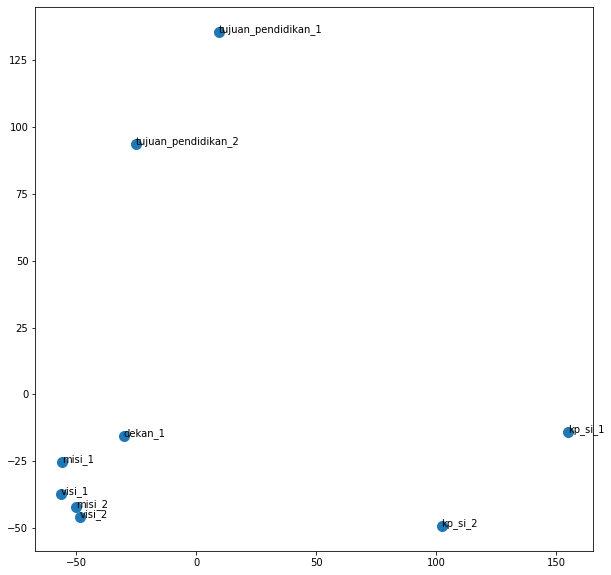

In [83]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

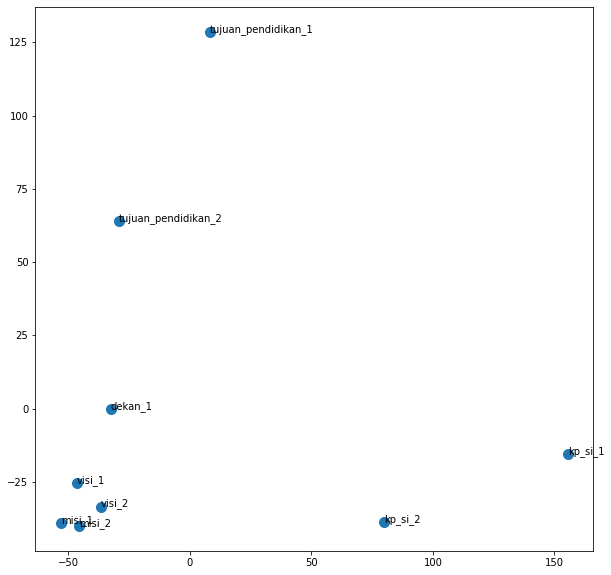

In [102]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

# Reset Cache

In [ ]:
import torch

torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=None, abbreviated=False))